In [14]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import matplotlib
assert matplotlib.get_backend() == "nbAgg"

In [56]:
import gym
import time, copy
import numpy as np
import rdb.envs.drive2d
from tqdm.notebook import tqdm, trange
from rdb.optim.open import shooting_optimizer
from rdb.optim.runner import Runner
from rdb.visualize.plot import plot_3d, plot_episode
from rdb.visualize.save import save_rewards
from rdb.visualize.preprocess import normalize_features

In [28]:
## Handles
VIZ_TRAINING = False
FRAME_WIDTH = 450

In [43]:
## Environment setup
env = gym.make("Week3_02-v0")
env.reset()
main_car = env.main_car
udim = 2
horizon = 10
T = 20
optimizer = shooting_optimizer(
    env.dynamics_fn, main_car.cost_runtime, udim, horizon, env.dt, T=T
)
runner = Runner(env, main_car)

### Training Environments

In [30]:
## Training environments
train_pairs = [(0.4, -0.2), (0.7, 0.2), (-0.5, 0.2), (0.5, 0.0)]

In [49]:
## Some interesting bad scenarios
#  Bad: (0.3, -0.1)

In [51]:
## Define weights
weights = {
    "dist_cars": 40.0,
    "dist_lanes": 50.0,
    "dist_fences": 1.0,
    "speed": 100.0,
    "control": 8.0,
}

Training [0] Position [(0.4, -0.2)]
Total cost: 0.001


<IPython.core.display.Javascript object>


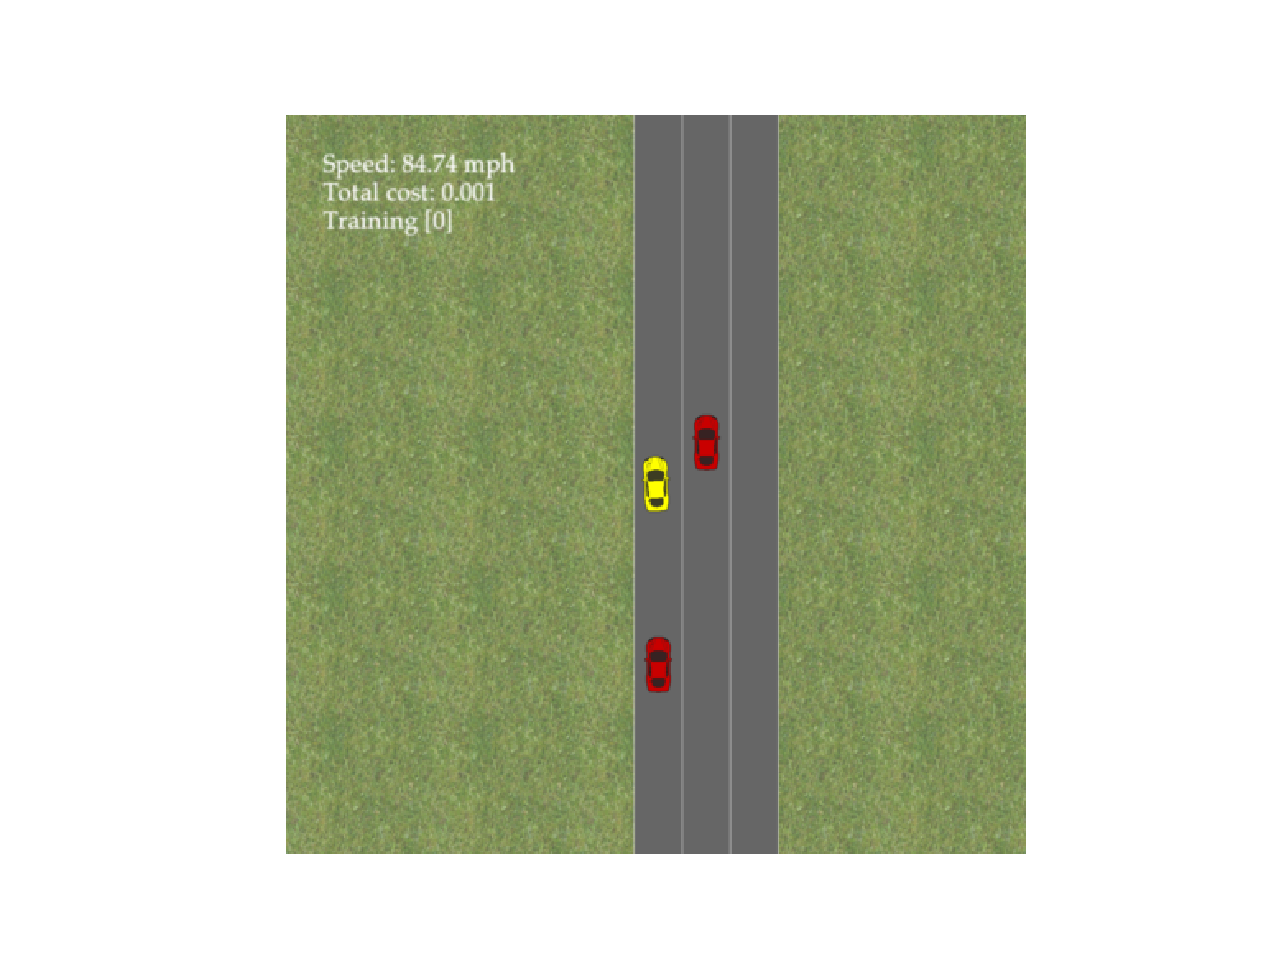

Training [1] Position [(0.7, 0.2)]
Total cost: 0.002


<IPython.core.display.Javascript object>


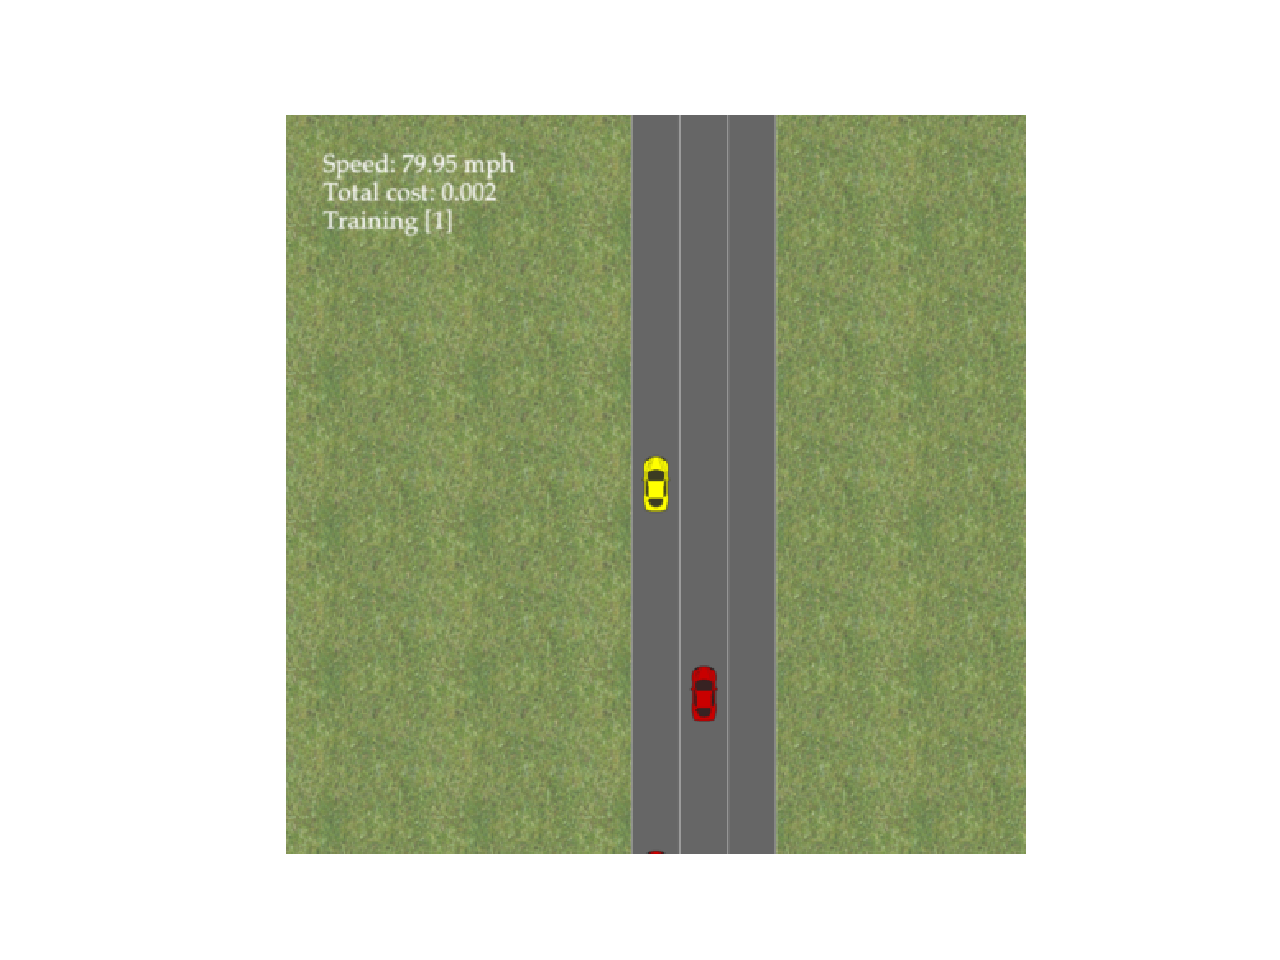

Training [2] Position [(-0.5, 0.2)]
Total cost: 0.001


<IPython.core.display.Javascript object>


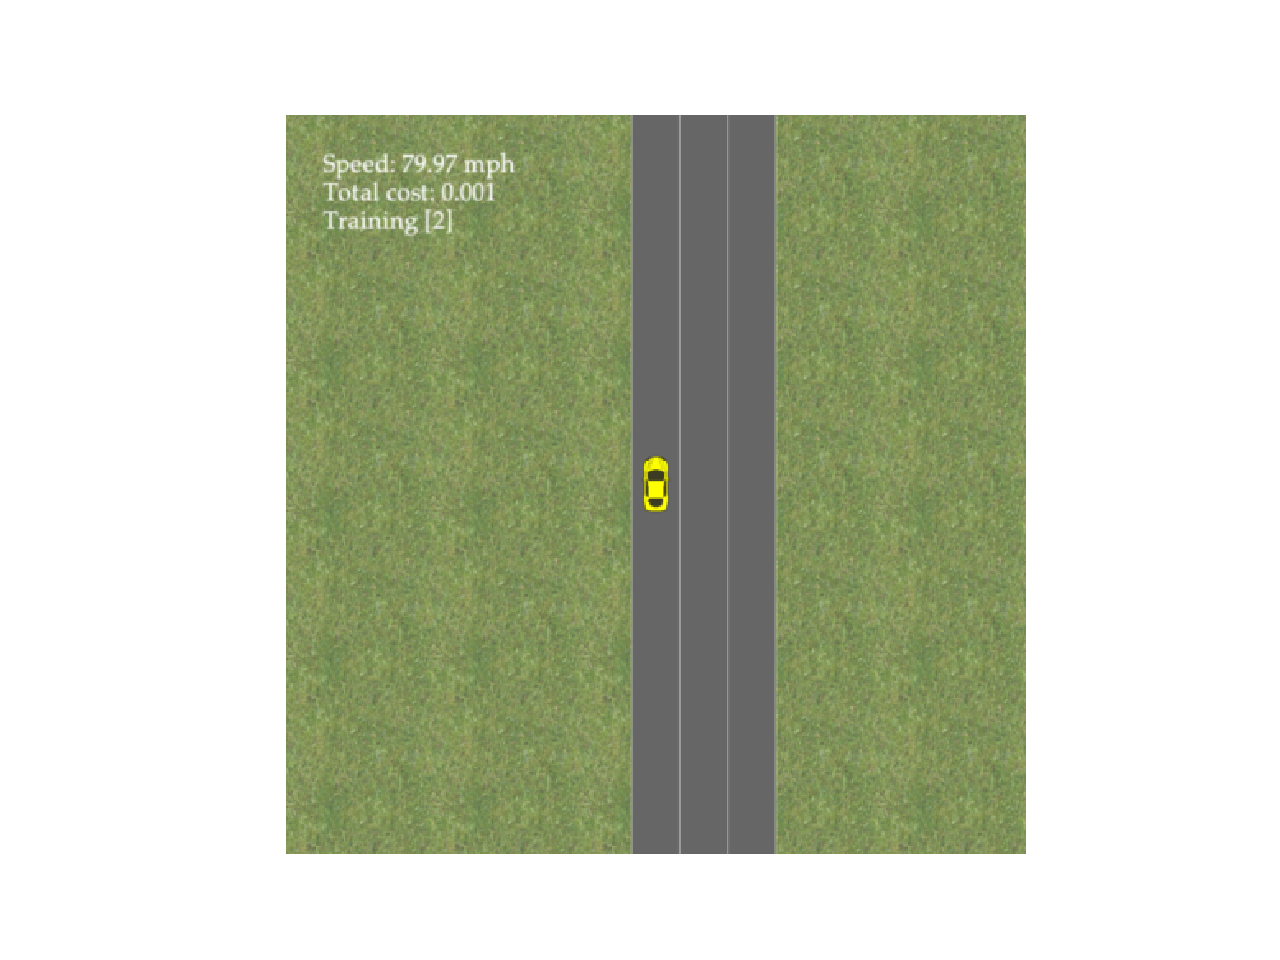

Training [3] Position [(0.5, 0.0)]
Total cost: 0.001


<IPython.core.display.Javascript object>


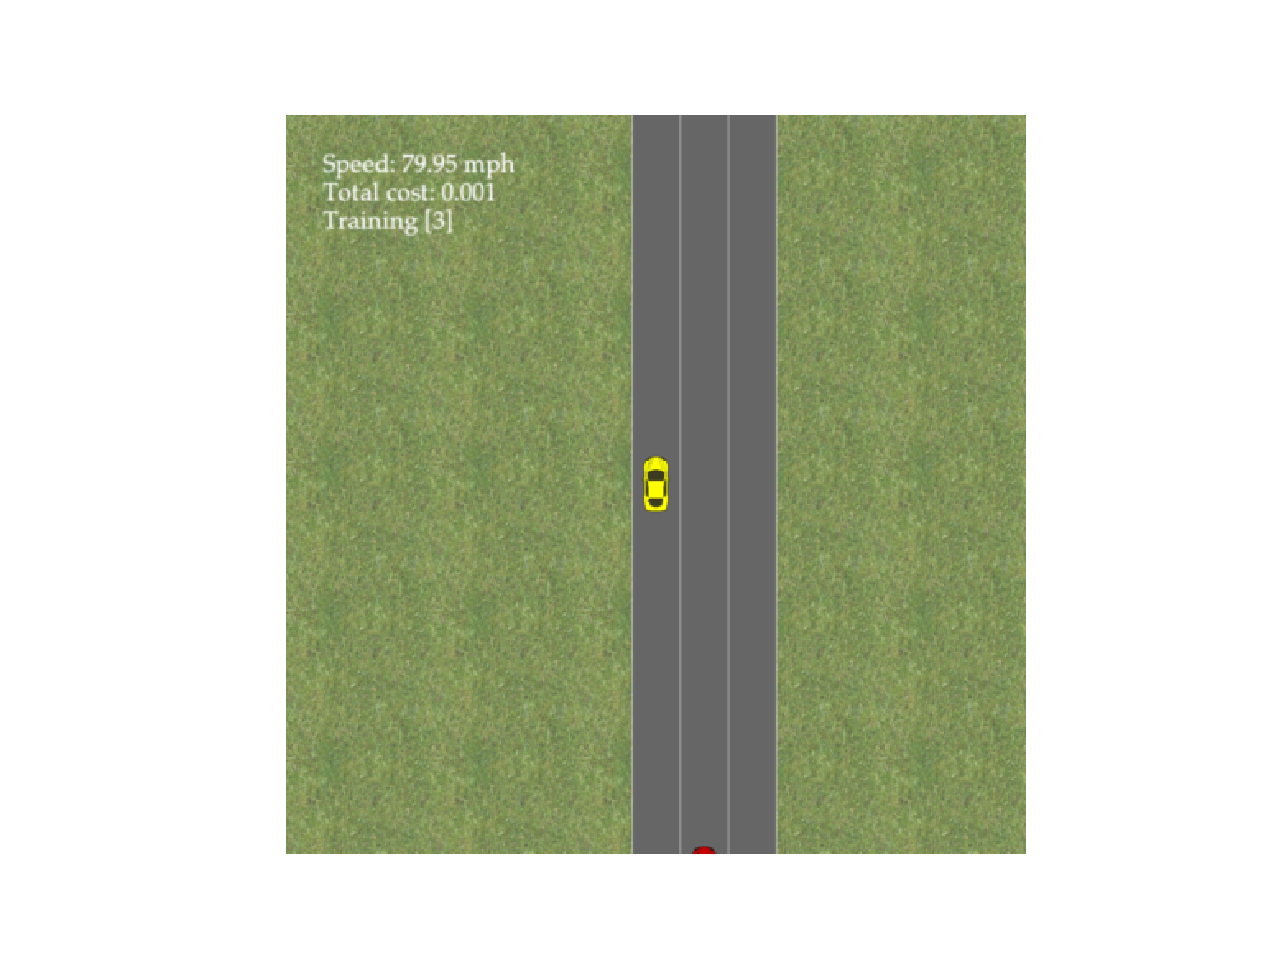

In [50]:
## Visualize Training environments
for idx, (y0, y1) in enumerate(tqdm(train_pairs, desc="Training Tasks")):
    env.set_init_state(y0, y1)
    env.reset()
    state = env.state

    actions = optimizer(state, weights=weights)
    traj, cost, info = runner(state, actions)
    print(f"Training [{idx}] Position [{(y0, y1)}]")
    print(f"Total cost: {cost:.3f}")
    text = f"Total cost: {cost:.3f}\nTraining [{idx}]"
    total_cost = 0
    mode = "human" if VIZ_TRAINING else "rgb_array"
    frames = runner.collect_frames(actions, FRAME_WIDTH, mode, text)
    plot_episode(frames, f"Training [{idx}]")


### Testing Environments

In [58]:
y0_range = np.arange(-0.5, 0.51, 0.05)
y1_range = np.arange(-0.5, 0.51, 0.05)

num0, num1 = len(y0_range), len(y1_range)
feats_keys = env.get_features_keys()
feats_sum = {key: np.zeros((num0, num1)) for key in feats_keys}

In [60]:
## Generate trajectories in testing environments
rews = [[] for _ in range(num0)]

for i0 in trange(num0, desc="y0"):
    y0 = y0_range[i0]
    for i1 in trange(num1, desc="y1", leave=False):
        y1 = y1_range[i1]
        env.set_init_state(y0, y1)
        env.reset()
        state = env.state

        actions = optimizer(state, weights=weights)
        traj, cost, info = runner(state, actions)
        rews[i0].append(-1.0 * cost)
        # print(f"y0 ({y0:.2f}) y1 ({y1:.2f}) cost ({cost:.2f})")
        for key in info["feats_sum"].keys():
            feats_sum[key][i0][i1] = info["feats_sum"][key]


In [61]:
# Normalize all trajetory features
feats_sum, normalize_info = normalize_features(feats_sum)

In [62]:
# Save rewards
np.savez("191111.npz", 
         xs=y0_range, 
         ys=y1_range, 
         rews=rews, 
         feats_sum=feats_sum, 
         normalize_info=normalize_info, 
         allow_pickle=True)

In [63]:
data = np.load("191111.npz", allow_pickle=True)
y0_range = data['xs']
y1_range = data['ys']
rews = data['rews']
feats_sum = data['feats_sum'].item()
normalize_info = data['normalize_info'].item()

<IPython.core.display.Javascript object>


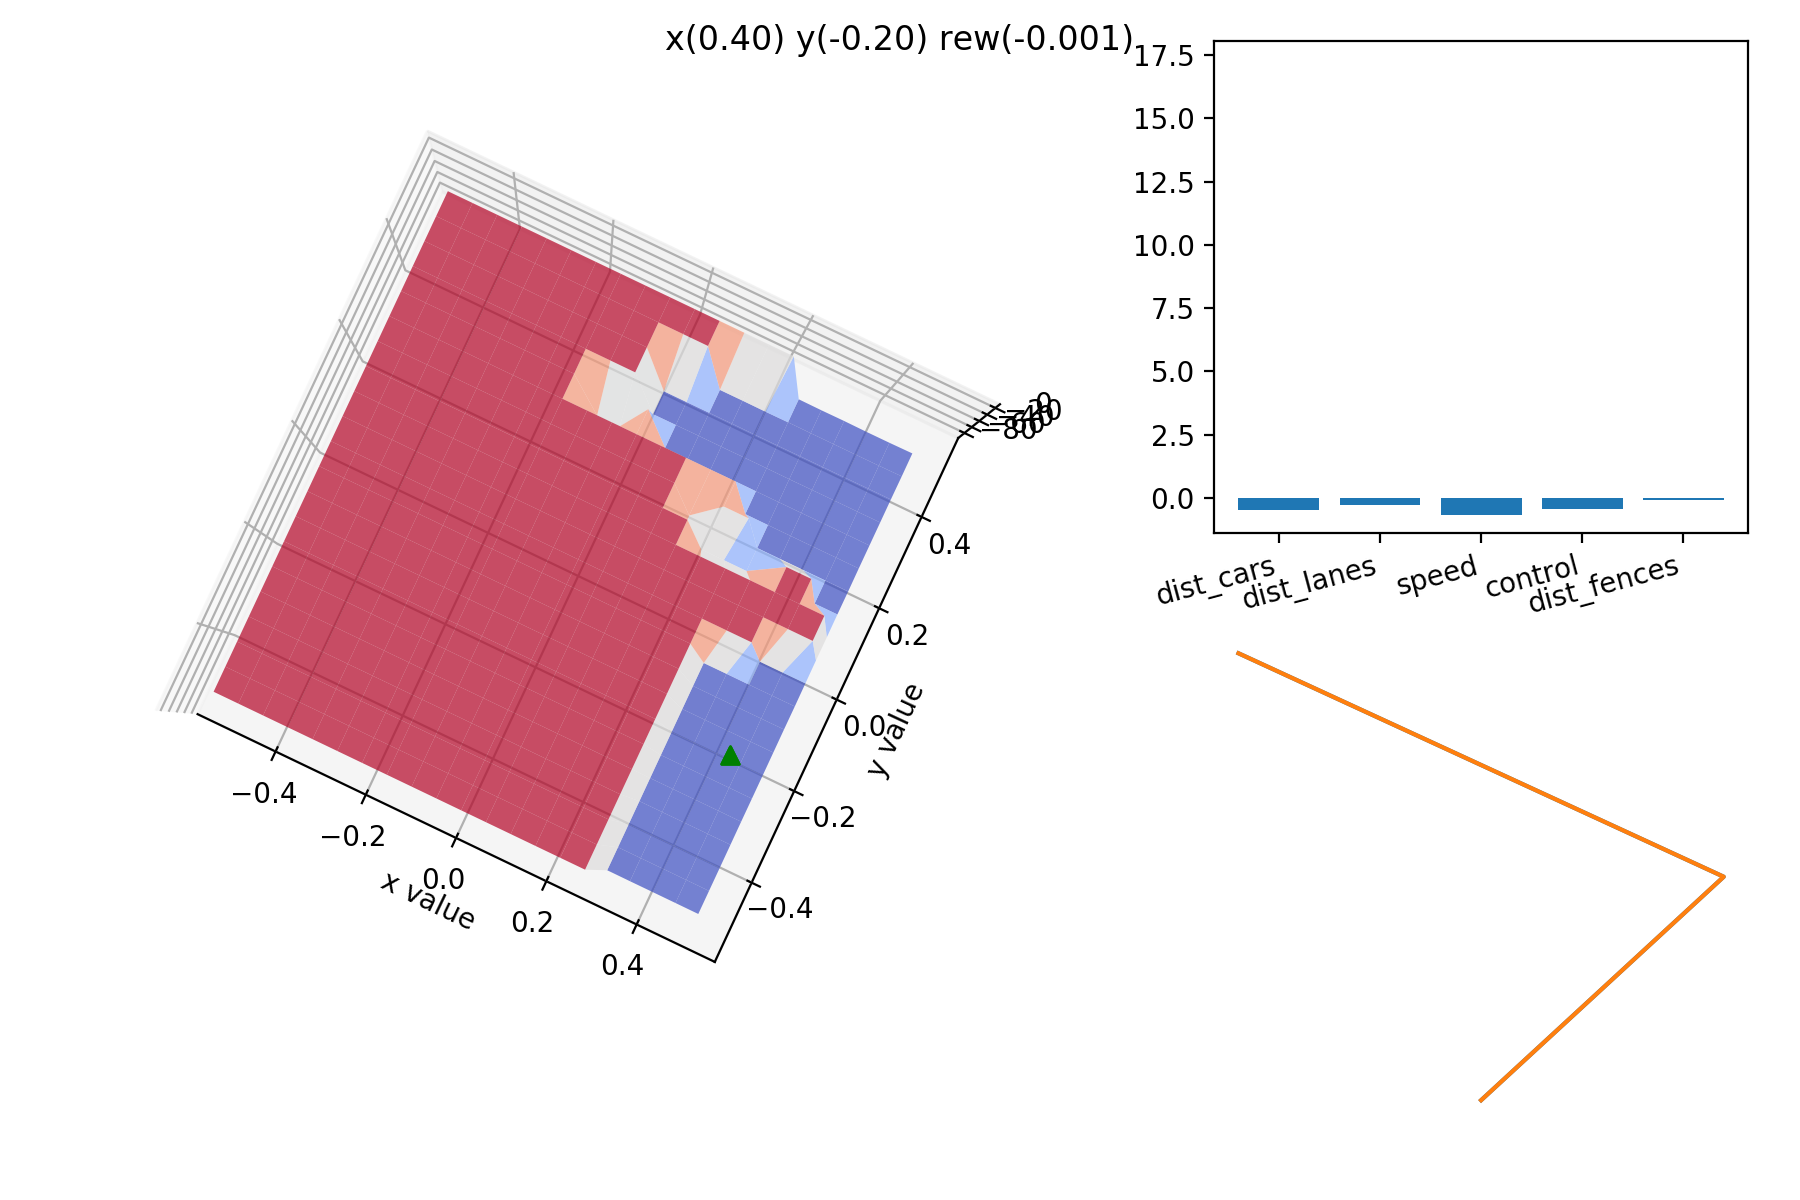

In [66]:
import matplotlib.pyplot as plt 
from os.path import join, dirname, isfile, isdir
from os import listdir
from matplotlib import gridspec
from matplotlib import cm
from mpl_toolkits import mplot3d
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
from imageio import imread

marker_points = []
record_images = []

def plot_3d_interactive_features(xs, ys, zs, feats, video_path_fn=None):
    # transparency
    ALPHA = 0.7
    # generate some data
    x = np.arange(0, 10, 0.2)
    y = np.sin(x)
    # Plot 3D
    fig = plt.figure(figsize=(9, 6)) 
    gs0 = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 
    ax0 = fig.add_subplot(gs0[:, :-1], projection="3d")
    #ax0.plot(x, y)
    X3d, Y3d = np.meshgrid(xs, ys)
    Z3d = np.array(zs)
    surf = ax0.plot_surface(X3d, Y3d, Z3d, cmap=cm.coolwarm, alpha=ALPHA, 
                            linewidth=0, antialiased=True, rstride=1, cstride=1)
    ax0.set_xlabel("x value")
    ax0.set_ylabel("y value")
    
    # Plot assisting figures
    gs01 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[1])
    ax10 = fig.add_subplot(gs01[:-1, -1])
    ax11 = fig.add_subplot(gs01[-1, -1])
    ax11.plot(x, y)
    plt.tight_layout()
    
    # Feature range
    feat_keys = list(feats.keys())
    min_feats = [np.min(feats[key]) for key in feat_keys]
    max_feats = [np.max(feats[key]) for key in feat_keys]

    ix, iy = 0, 0
    vals = [feats[key][ix][iy] for key in feat_keys]
    xbar = np.arange(len(feat_keys))
    ax10.clear()
    ax10.set_xticks(xbar, feat_keys)
    ax10.set_ylim(min(min_feats), max(max_feats))
    ax10.bar(xbar, vals)

    
    def onclick(event):
        global ex, ey
        ex, ey = event.xdata, event.ydata
        #plt.suptitle(f"Clicked at x({ex:.2f}), y({ey:.2f})")
        #ix = np.argmin(np.abs(xs - ex))
        #iy = np.argmin(np.abs(ys - ey))
        #plt.suptitle(f"x({ex:.2f}) y({ey:.2f}) rew({rews[]})")
        #plot_feats(ix, iy)
    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    
    def display_video(video_path=None):
        pass

    def get_video_abs_path(ix, iy):
        pass

    points = []
    def plot_feats(ix, iy):
        global marker_points
        # plot bar chart
        OFFSET = 4
        SIZE = 40
        
        vals = [feats[key][ix][iy] for key in feat_keys]
        xbar = np.arange(len(feat_keys))
        ax10.clear()
        ax10.set_ylim(min(min_feats), max(max_feats))
        ax10.bar(xbar, vals, tick_label=feat_keys)
        ax10.set_xticklabels(ax10.get_xticklabels(), rotation=15, ha='right')
        # plot 3d surface marker
        vx, vy = xs[ix], ys[iy]
        vz = rews[ix][iy]
        for p in marker_points:
            p.remove()
        marker_points = []
        for x, y, z in zip([vx, vx], [vy, vy], [vz + OFFSET, vz + OFFSET]):
            point = ax0.scatter(x, y, z, marker='^', c='g', s=SIZE)
            marker_points.append(point)
        # plot title
        plt.suptitle(f"x({xs[ix]:.2f}) y({ys[iy]:.2f}) rew({rews[ix][iy]:.3f})")
        
        # show video (optional)
        video_path = get_video_abs_path(ix, iy)
        if not video_path:
            ax11.clear()
            ax11.axis("off")
            display_video()
        else:
            ax11.axis("on")
            display_video(video_path)
            
    plot_feats(0, 0)

    def slide_xy(x, y):
        global ix, iy
        ix = int(np.argmin(np.abs(xs - x)))
        iy = int(np.argmin(np.abs(ys - y)))
        plot_feats(ix, iy)
    
    # slider widgets
    slider_x = widgets.FloatSlider(min=min(xs), max=max(xs) + 0.01, value=0.)
    slider_y = widgets.FloatSlider(min=min(ys), max=max(ys) + 0.01, value=0.)
    interactive(slide_xy, x=slider_x, y=slider_y)
    
    # Play video widget
    def get_video_abs_path(ix, iy):
        if video_path_fn is None:
            return None
        vx, vy = xs[ix], ys[iy]
        path = join(dirname(rdb.__file__), "..", video_path_fn(vx, vy))
        if not isdir(path):
            return None
        return path

    video_player = widgets.Play(
        interval=100,
        value=0,
        min=0,
        max=100,
        step=1,
        description="Press play",
        disabled=False
    )
    video_slider = widgets.IntSlider()
    widgets.jslink((video_player, 'value'), (video_slider, 'value'))

    def display_video(video_path=None):
        global record_images
        record_images = []
        if video_path is None:
            video_player.max = 0
        else:
            files = sorted([f for f in listdir(video_path) if ".png" in f])
            nframes = len(files)
            record_images = [imread(join(video_path, f)) for f in files]
            video_slider.value = 0
            ax11.imshow(record_images[0])

    def view_image(i):
        ax11.imshow(record_images[i])
    interactive(view_image, i=video_slider)
            
    display_video(get_video_abs_path(0, 10))
    #ax11.imshow(record_images[0])

    selector_box = widgets.VBox([slider_x, slider_y])
    video_box = widgets.HBox([video_player, video_slider])
    ui = widgets.HBox([selector_box, video_box])
    display(ui)

    
def video_path_fn(x, y):
    return f"data/191111/y0({x:.2f})_y1({y:.2f})"

plot_3d_interactive_features(y0_range, y1_range, rews, feats_sum, video_path_fn)

In [164]:
print(np.array(rews)[0])
print(y0_range[0])

[ 119.6815    119.6815    119.6815    119.68188   119.68135   119.68104
 -543.6035    119.68179   119.68137    28.89479    28.512749]
-0.5


In [179]:
play = widgets.Play(
#     interval=10,
    value=50,
    min=0,
    max=100,
    step=1,
    description="Press play",
    disabled=False
)
slider = widgets.IntSlider()
widgets.jslink((play, 'value'), (slider, 'value'))
widgets.HBox([play, slider])

In [181]:
play.max = 20